In [7]:
import requests
web = requests.get("https://comic.naver.com/webtoon?tab=mon")

if web.status_code == 200:
    print(web.text)





<!DOCTYPE html>
<html lang="ko">
<head>
	<title>네이버 웹툰</title>
	<link rel="shortcut icon" href="https://ssl.pstatic.net/static/m/comic/im/favicon/1804/webtoon_favicon_32x32.ico" type="image/x-icon">

	<meta charset="utf-8" />
	<meta http-equiv="x-ua-compatible" content="ie=edge" />
	<meta property="og:type" content="article">
	<meta property="og:article:author" content="네이버 웹툰">
	<meta property="og:article:author:url" content="https://comic.naver.com">
	<meta property="og:title" content="네이버 웹툰">
	<meta property="og:image" content="https://ssl.pstatic.net/static/comic/images/og_tag_v2.png">
	<meta property="og:description" content="매일매일 새로운 재미, 네이버 웹툰.">

	<script>
		if (/MSIE \d|Trident.*rv:/.test(navigator.userAgent)) {
			window.location = 'microsoft-edge:' + window.location;
			setTimeout(function () {
				window.location = 'https://go.microsoft.com/fwlink/?linkid=2135547';
			}, 1);
		}
	</script>
	<script async src='https://ssl.pstatic.net/tveta/libs/glad/prod/gfp-core.js'></

In [8]:
from selenium import webdriver
from chromedriver_autoinstaller import install
ca = install()
driver = webdriver.Chrome()
driver.implicitly_wait(10)
driver.get("https://comic.naver.com/webtoon?tab=mon")

In [9]:
from selenium.webdriver.common.by import By

In [10]:
def image_download(path, link):
    data = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"}
    img = requests.get(link, headers=data)
    with open(path, 'wb') as w:
        w.write(img.content)

In [11]:
from threading import Thread
from tqdm.notebook import tqdm
thr = []
driver.implicitly_wait(1)
items = driver.find_elements(By.XPATH, '//*[@id="container"]/div[3]/div[2]/div/ul/li')
for item in tqdm(items):
    try:
        image = item.find_element(By.TAG_NAME, "img")
        title = item.find_element(By.CSS_SELECTOR, 'a > span > span.text')
       
        path = f"./images/{title.text}.jpg"
        link = image.get_attribute('src')
        thr.append(Thread(target=image_download, args=(path, link)))
        # image_download(path, link)
        # print(title.text, link)
    except Exception:
        pass
for t in thr:
    t.start()
for t in tqdm(thr):
    t.join()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [12]:
import pandas as pd
driver.implicitly_wait(1)
items = driver.find_elements(By.CSS_SELECTOR, "ul > li.item")
lis = []
for item in tqdm(items):
    
    title = item.find_element(By.CSS_SELECTOR, 'a > span > span.text')
    rate = item.find_element(By.CSS_SELECTOR, "div.rating_area > span > span")
    lis.append(dict(title=title.text, rate=float(rate.text)))


df = pd.DataFrame(lis)
df.head()

  0%|          | 0/92 [00:00<?, ?it/s]

,title,rate
0,뷰티풀 군바리,9.81
1,왕과의 야행,9.98
2,12시네점심,9.94
3,백수세끼,9.85
4,신의 탑,9.87


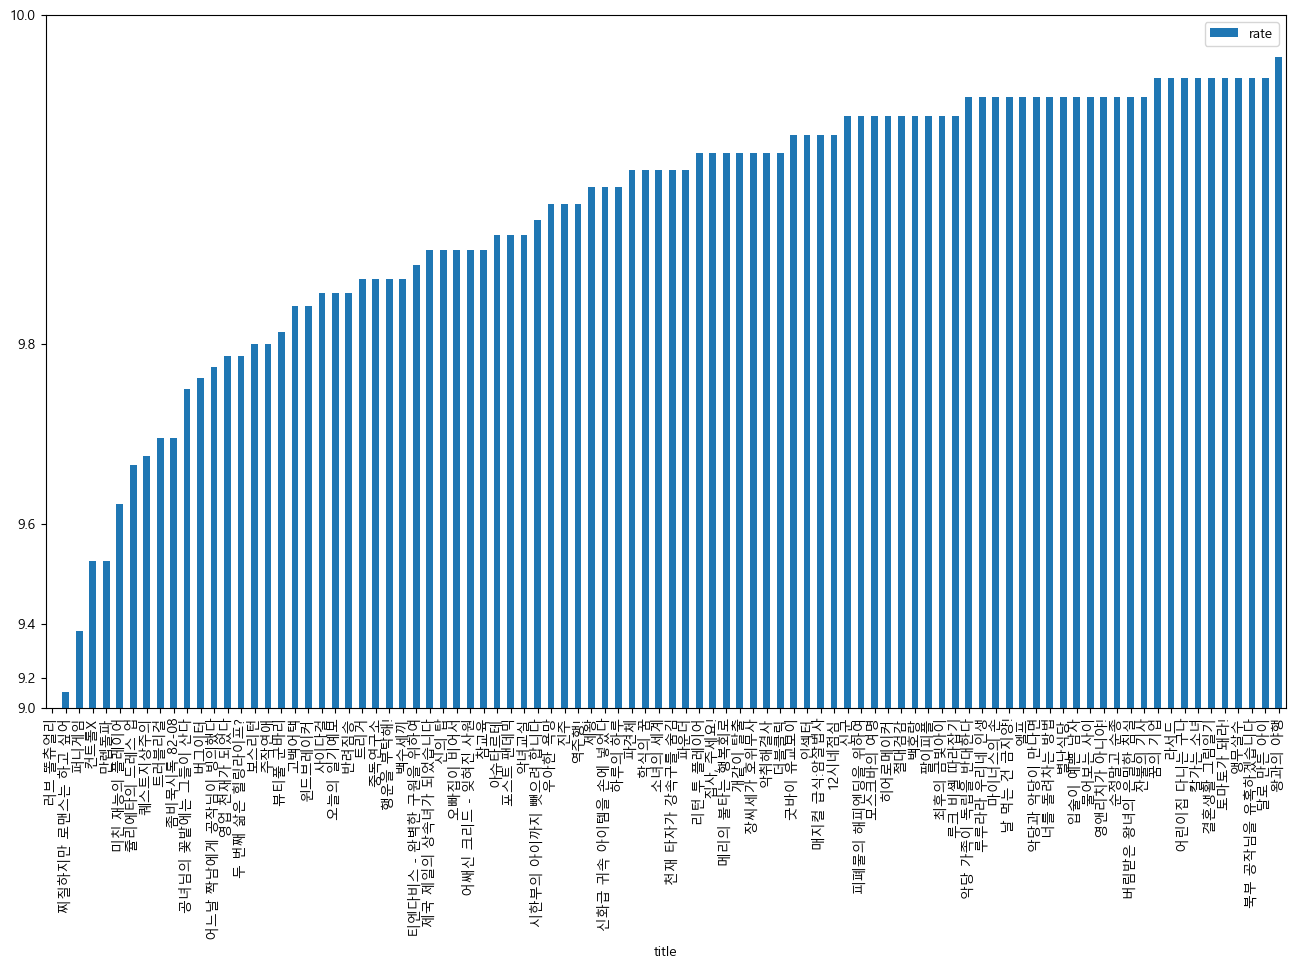

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.scale import ScaleBase
from matplotlib.transforms import Transform
from matplotlib.scale import register_scale
class SquareScale(ScaleBase):
    name = 'square'

    def __init__(self, axis, **kwargs):
        super().__init__(axis)

    class SquareTransform(Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a):
            return np.power(20, a)

        def inverted(self):
            return SquareScale.InverseSquareTransform()

    class InverseSquareTransform(Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a):
            return np.power(20, a)

        def inverted(self):
            return SquareScale.SquareTransform()

    def get_transform(self):
        return self.SquareTransform()

    # 새로 추가된 메소드
    def set_default_locators_and_formatters(self, axis):
        """
        축에 대한 기본 위치 지정자와 포맷터를 설정합니다.
        이 경우, 선형 축의 기본값을 사용합니다.
        """
        from matplotlib.ticker import AutoLocator, ScalarFormatter
        axis.set_major_locator(AutoLocator())
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_locator(AutoLocator())
        axis.set_minor_formatter(ScalarFormatter())

# 사용자 정의 스케일을 등록
register_scale(SquareScale)


df = df.sort_values(by='rate')
plt.rc('font', family='Malgun Gothic')
df.plot.bar(x='title', y='rate', figsize=(16, 9), )
plt.yscale('square')
plt.ylim((9.0, 10))
plt.show()

In [16]:
from tqdm.notebook import trange
pagelink = "https://comic.naver.com/webtoon/list?titleId=650305&page={}&sort=ASC&tab=mon"
rates = []
driver.get(pagelink.format(1))
page_count = driver.find_element(
    By.XPATH, '//*[@id="content"]/div[3]/div[1]/div[1]')
page_count = int(
    ''.join([text for text in page_count.text if text.isdecimal()]))//20+1
driver.implicitly_wait(10)
for i in trange(1, page_count+1):
    driver.get(pagelink.format(i))
    rates_raw = driver.find_elements(
        By.XPATH, '//*[@id="content"]/div[3]/ul/li/a/div[2]/div/span[1]/span')
    rates += [float(rate.text) for rate in rates_raw]

  0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
len(rates)

413

In [18]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std_data = std.fit_transform(rates)

ValueError: Expected 2D array, got 1D array instead:
array=[9.97 9.98 9.98 9.98 9.97 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98
 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.94 9.96 9.98 9.98 9.97 9.98
 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.97 9.96 9.98 9.96 9.97 9.98
 9.96 9.96 9.98 9.98 9.98 9.97 9.98 9.98 9.98 9.97 9.98 9.98 9.98 9.98
 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98 9.98
 9.98 9.98 9.98 9.98 9.94 9.98 9.97 9.98 9.98 9.98 9.98 9.97 9.98 9.98
 9.98 9.98 9.98 9.98 9.98 9.98 9.99 9.98 9.98 9.98 9.98 9.98 9.98 9.98
 9.98 9.99 9.99 9.99 9.99 9.99 9.99 9.99 9.99 9.99 9.98 9.98 9.99 9.98
 9.98 9.98 9.98 9.98 9.99 9.98 9.98 9.99 9.99 9.99 9.99 9.98 9.98 9.99
 9.99 9.99 9.99 9.99 9.99 9.99 9.99 9.99 9.99 9.99 9.99 9.99 9.94 9.98
 9.98 9.98 9.98 9.98 9.98 9.98 9.99 9.98 9.98 9.98 9.98 9.99 9.99 9.98
 9.98 9.98 9.98 9.99 9.98 9.98 9.99 9.98 9.98 9.97 9.98 9.98 9.98 9.98
 9.98 9.98 9.97 9.98 9.97 9.98 9.99 9.94 9.96 9.98 9.98 9.97 9.98 9.98
 9.98 9.97 9.98 9.96 9.97 9.98 9.97 9.98 9.98 9.97 9.91 9.97 9.97 9.97
 9.98 9.95 9.97 9.98 9.97 9.98 9.98 9.99 9.98 9.98 9.99 9.98 9.99 9.98
 9.98 9.99 9.98 9.97 9.98 9.98 9.98 9.98 9.98 9.96 9.97 9.95 9.97 9.96
 9.98 9.97 9.97 9.98 9.98 9.98 9.98 9.98 9.98 9.96 9.97 9.97 9.98 9.97
 9.98 9.98 9.98 9.96 9.97 9.97 9.97 9.94 9.91 9.89 9.9  9.82 9.86 9.96
 9.96 9.98 9.96 9.96 9.97 9.98 9.97 9.96 9.96 9.94 9.97 9.97 9.96 9.91
 9.97 9.96 9.97 9.97 9.96 9.98 9.97 9.97 9.97 9.87 9.95 9.97 9.97 9.97
 9.97 9.93 9.98 9.96 9.97 9.94 9.97 9.98 9.97 9.96 9.94 9.94 9.83 9.95
 9.91 9.91 9.93 9.93 9.97 9.95 9.96 9.91 9.93 9.93 9.96 9.96 9.92 9.95
 9.91 9.95 9.94 9.93 9.94 9.95 9.9  9.9  9.89 9.89 9.93 9.86 9.81 9.42
 8.5  9.45 8.89 8.88 9.5  9.39 9.19 9.24 9.88 9.9  9.92 9.94 9.92 9.97
 9.97 9.97 9.97 9.96 9.95 9.96 9.96 9.97 9.97 9.96 9.97 9.96 9.94 9.95
 9.9  9.95 9.91 9.9  9.93 9.87 9.88 9.35 9.17 9.77 9.83 9.75 9.66 9.61
 9.84 9.57 9.79 9.11 9.36 9.   9.1  9.78 9.79 9.72 9.85 9.63 9.04 9.19
 8.85 9.55 8.92 8.95 8.8  9.4  9.83 9.77 9.8  9.82 9.81 9.86 9.74 9.88
 9.71 9.75 9.8  9.75 9.42 9.65 9.37 9.49 9.47 9.62 9.37 8.12 6.82 8.31
 9.13 8.79 8.61 9.44 9.46 9.72 9.62].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

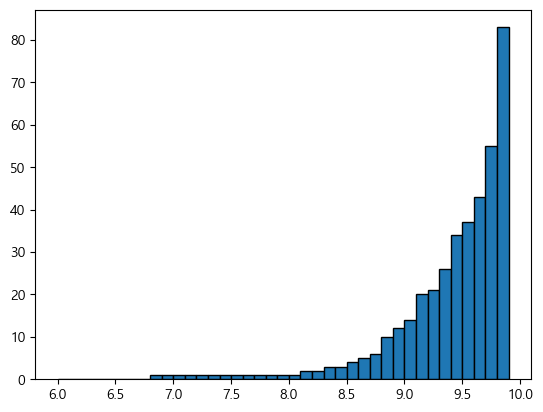

In [19]:
ranges = [6 + i*0.1 for i in range(40)]
plt.hist(rates, bins=ranges, edgecolor='black',cumulative=True)
plt.show()

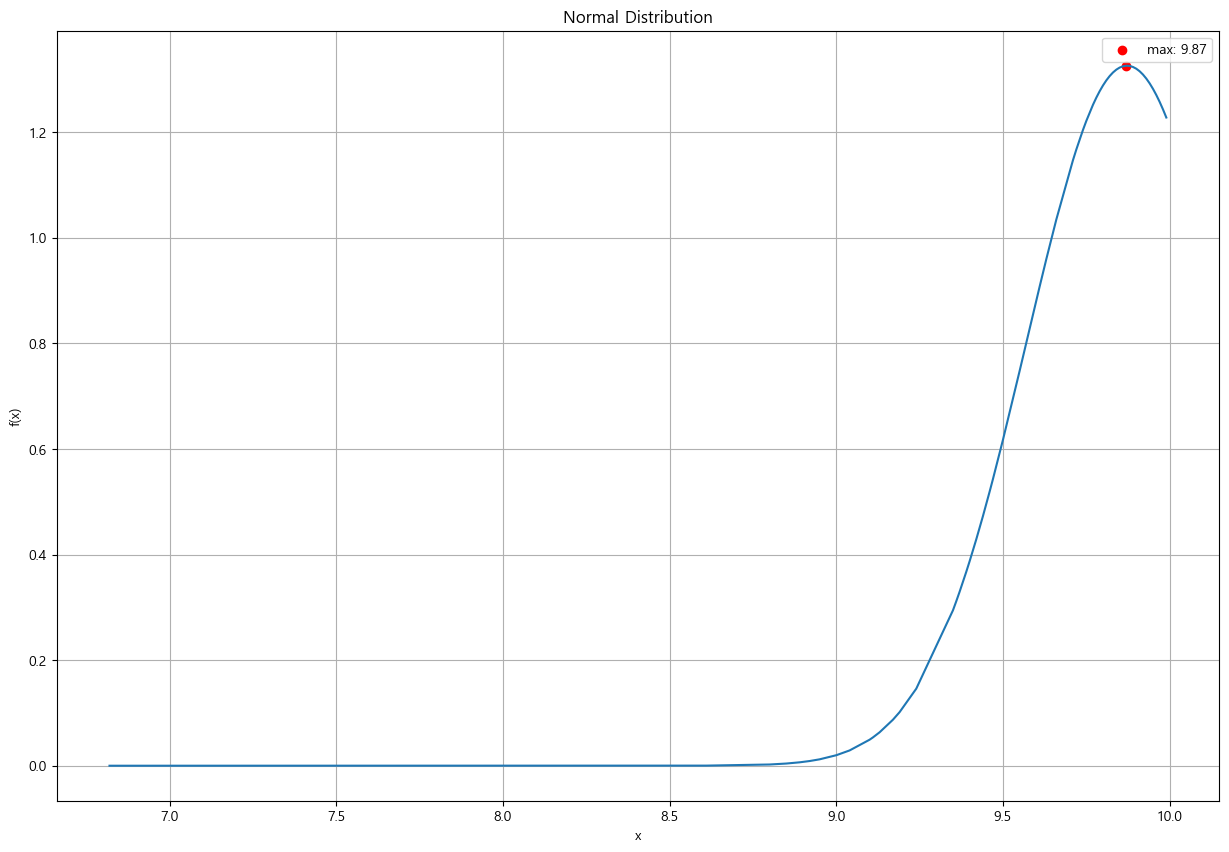

In [25]:
import matplotlib.pyplot as plt #1
import numpy as np #2
from scipy.stats import norm #3

rates = np.array(rates)
rates.sort()
plt.figure(figsize=(15,10)) #5
plt.title('Normal Distribution') #6
plt.xlabel('x') #7
plt.ylabel('f(x)') #8
plt.grid() #9
pdf = norm.pdf(rates, loc=rates.mean(), scale=rates.std())
plt.plot(rates, pdf) #10
plt.scatter(rates[pdf.argmax()], pdf.max(), label=f"max: {rates[pdf.argmax()]}",color='red')
plt.legend()
plt.show() #11